 ## Imports and Setup

In [1]:
import os
import sys
import numpy as np
import torch
import random
from tqdm.notebook import tqdm
import wandb
import timm
from pathlib import Path


# Add the src directory to the sys.path
sys.path.append(os.path.abspath('..'))

from secret_runway_detection.model import CombinedModel, SegmentationHead

# Set random seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


 ## Configuration Parameters

In [2]:
DEBUG = True

# BUFFER_TYPE = 'cross'
RUN_PATH = 'esedx12/secret-runway-detection/hq7a4zv3'

# IS_ON_WANDB = True
# RUN_NAME = 'neat-energy-31'
# MODEL_NAME = 'model:v7'

# # Model input and output dimensions
# INPUT_IMAGE_SIDE_LEN_PX = 224  # in pixels
# TILES_PER_INPUT_AREA_LEN = 224  # Number of tiles per side in one input area

# Threshold for converting model outputs to binary predictions
THRESHOLD = 0.5  # Adjust based on validation performance

In [3]:
# # Path to the trained model checkpoint
# MODEL_CHECKPOINT_PATH = '../checkpoints/trained_model.pth'  # Update this path

In [4]:
# Load the W&B run
train_run = wandb.Api().run(RUN_PATH)

 ## Load the Trained Model

In [5]:
from more_itertools import one

# Fetch the model artifact from the W&B run
artifacts = train_run.logged_artifacts()
artifact = one(artifacts)  # Ensures exactly one artifact
state_dict_dir = artifact.download(root='../artifacts/')
state_dict_dir = Path(state_dict_dir)
state_dict_path = state_dict_dir / f'{train_run.name}.pth'
state_dict_path

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Downloading large artifact model:v8, 358.74MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.1


PosixPath('../artifacts/stilted-field-32.pth')

In [6]:
# Load model checkpoint from ../checkpoints dir
backbone = timm.create_model(
        'swin_base_patch4_window7_224',
        pretrained=False,
        num_classes=0,  # Assuming binary classification
    )

segmentation_head = SegmentationHead()

model = CombinedModel(backbone, segmentation_head)


In [28]:
backbone

SwinTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (layers): Sequential(
    (0): SwinTransformerStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=128, out_features=384, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=128, out_features=128, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path1): Identity()
          (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=128, out_features=512, bias=True)
            (act): GELU(approximate='none')
            (

In [7]:
# Load the Model from WandB, which we saved as state dict
model.load_state_dict(torch.load(state_dict_path, map_location=device))
model.eval()

/tmp/ipykernel_800637/1339217503.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(state_dict_path, map_location=device))


CombinedModel(
  (backbone): SwinTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (layers): Sequential(
      (0): SwinTransformerStage(
        (downsample): Identity()
        (blocks): Sequential(
          (0): SwinTransformerBlock(
            (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              (qkv): Linear(in_features=128, out_features=384, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=128, out_features=128, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softmax(dim=-1)
            )
            (drop_path1): Identity()
            (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            (mlp): Mlp(
              (fc1): Linear(in_features=128, out_features=51

In [8]:
best_threshold = train_run.summary['best_threshold']

## Load validation images and labels

In [9]:
train_dir = Path(
    f'../training_data/training_data_{train_run.config["training_dataset"]}')

images_dir = train_dir / 'images'
labels_dir = train_dir / 'labels'


In [10]:
# Get all filenames in the images directory
import re


all_filenames = os.listdir(images_dir)

# Initialize dictionaries and lists
strip_to_files = {}        # For files with strip numbers
possibly_empty_files = []  # For 'possibly_empty' files

# Regular expression pattern to match filenames with strip numbers
pattern = re.compile(r'^area_\d+_of_strip_(\d+)\.npy$')

# Process filenames
for filename in all_filenames:
    if 'possibly_empty' in filename:
        # This is a 'possibly_empty' file
        possibly_empty_files.append(filename)
    else:
        # Try to match the pattern to extract strip number
        match = pattern.match(filename)
        if match:
            strip_number = int(match.group(1))
            # Add filename to the list for this strip number
            strip_to_files.setdefault(strip_number, []).append(filename)
        else:
            print(f"Filename does not match expected pattern: {filename}")


In [11]:
val_strip_numbers = train_run.config['val_strip_numbers']

val_files = []
for strip_num in val_strip_numbers:
    val_files.extend(strip_to_files[strip_num])

train_strip_numbers = train_run.config['train_strip_numbers']

train_files = []
for strip_num in train_strip_numbers:
    train_files.extend(strip_to_files[strip_num])

In [19]:
# Define your transform if you have one; otherwise, set to None
from secret_runway_detection.dataset import LandingStripDataset, SegmentationTransform

segmentation_transform = SegmentationTransform()  # Replace with your actual transform if any
# segmentation_transform = None

# Create validation dataset
val_dataset = LandingStripDataset(
    images_dir=images_dir,
    labels_dir=labels_dir,
    file_list=val_files,
    transform=segmentation_transform
)

# Create training dataset
train_dataset = LandingStripDataset(
    images_dir=images_dir,
    labels_dir=labels_dir,
    file_list=train_files,
    transform=segmentation_transform
)


## Visualize Image, Label and Prediction

In [26]:
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.pyplot as plt
import numpy as np
import torch

# Function to visualize predictions with optional label overlay
def visualize_predictions(model, dataset, num_samples=5, overlay=False):
    model.eval()
    with torch.no_grad():
        for i in range(num_samples):
            sample = dataset[i]
            input_image = sample[0].unsqueeze(0)  # Add batch dimension
            label = sample[1]
            
            # Generate prediction
            prediction = model(input_image).squeeze(0)  # Remove batch dimension
            
            # Convert tensors to numpy arrays for visualization
            input_image_np = input_image.squeeze(0).numpy().transpose(1, 2, 0)  # HWC format
            label_np = label.numpy()
            prediction_np = prediction.numpy().squeeze(0)
            
            # Create subplots
            fig, ax = plt.subplots(1, 3 if not overlay else 3, figsize=(15, 5))
            
            # Display Input Image
            ax_idx = 0
            ax[ax_idx].imshow(input_image_np)
            ax[ax_idx].set_title('Input Image')
            ax[ax_idx].axis('off')
            
            if overlay:
                # Overlay Label on Input Image
                ax_idx += 1
                ax[ax_idx].imshow(input_image_np)
                ax[ax_idx].imshow(label_np, cmap='jet', alpha=0.5)  # Adjust alpha for transparency
                ax[ax_idx].set_title('Input Image with Label Overlay')
                ax[ax_idx].axis('off')
                
                # Display Prediction
                ax_idx += 1
                ax[ax_idx].imshow(prediction_np, cmap='gray')
                ax[ax_idx].set_title('Prediction')
                ax[ax_idx].axis('off')
            else:
                # Display Label
                ax_idx += 1
                ax[ax_idx].imshow(label_np, cmap='gray')
                ax[ax_idx].set_title('Label')
                ax[ax_idx].axis('off')
                
                # Display Prediction
                ax_idx += 1
                ax[ax_idx].imshow(prediction_np, cmap='gray')
                ax[ax_idx].set_title('Prediction')
                ax[ax_idx].axis('off')
            
            plt.show()


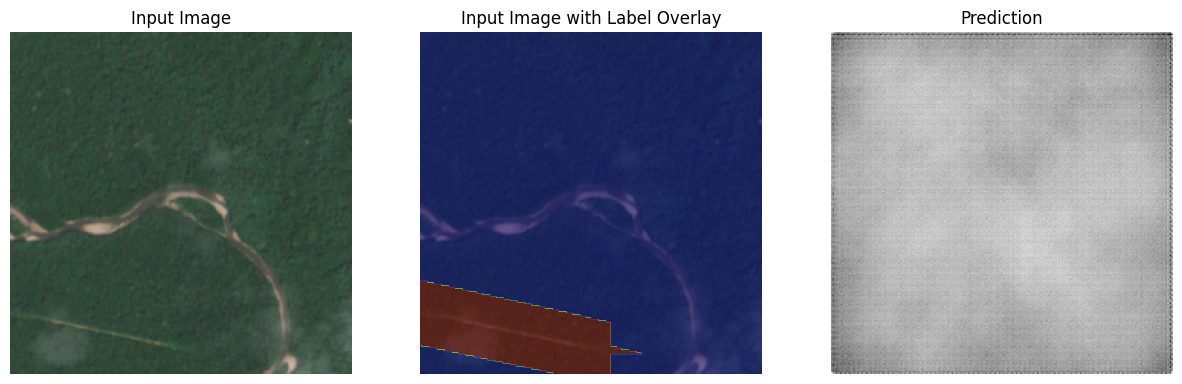

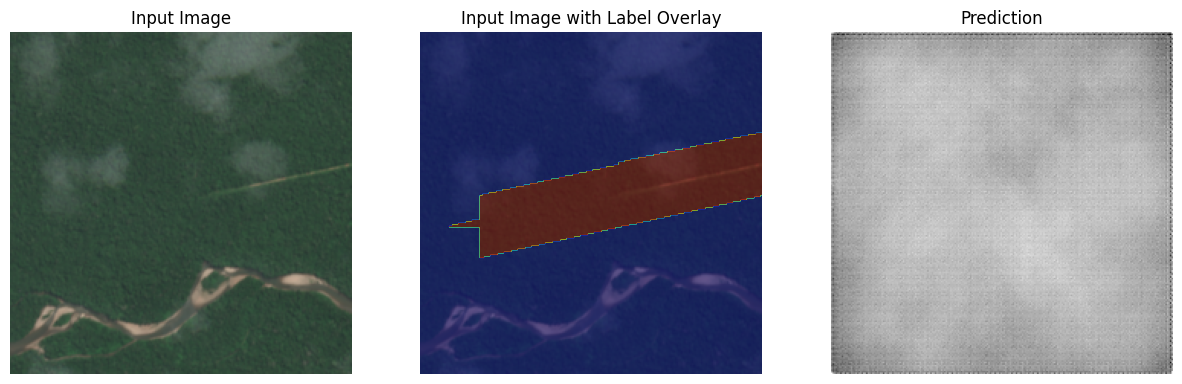

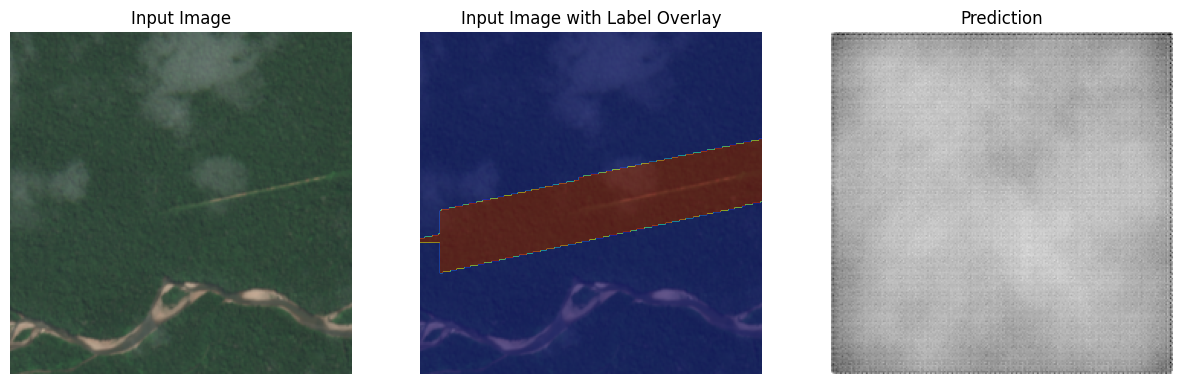

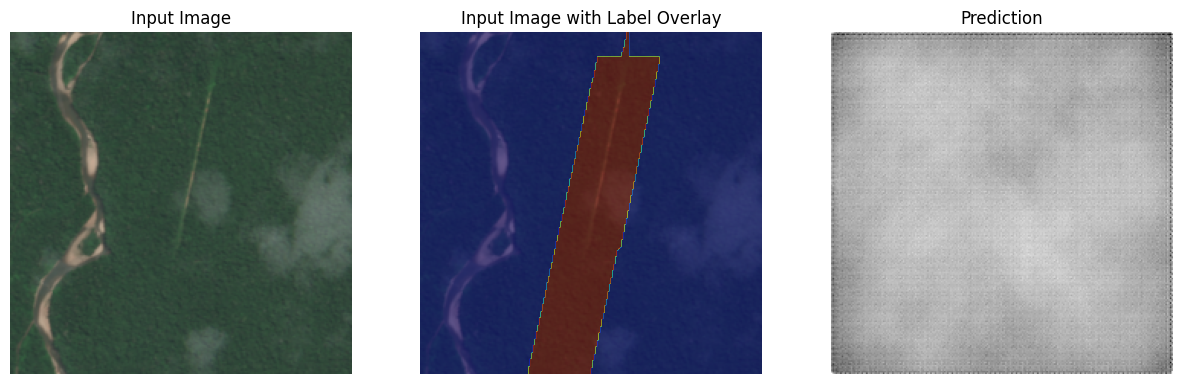

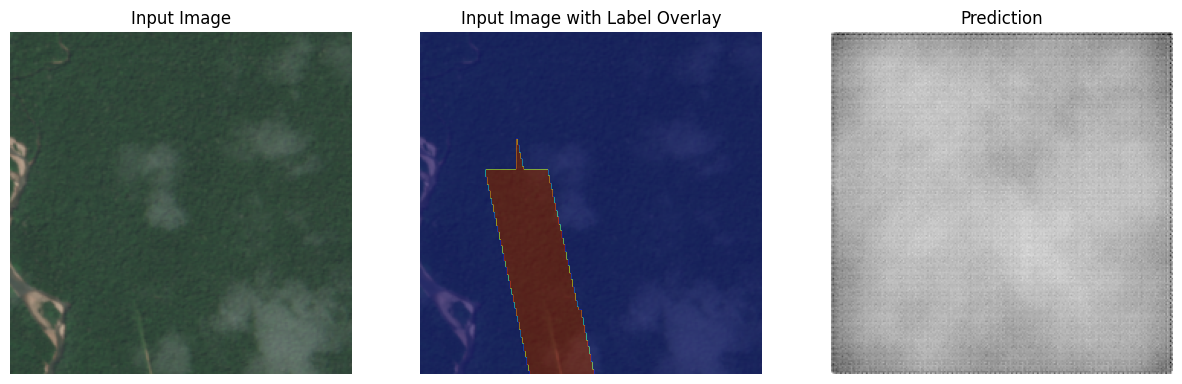

In [27]:
# Visualize predictions for a few VALIDATION samples
visualize_predictions(model, val_dataset, num_samples=5, overlay=True)

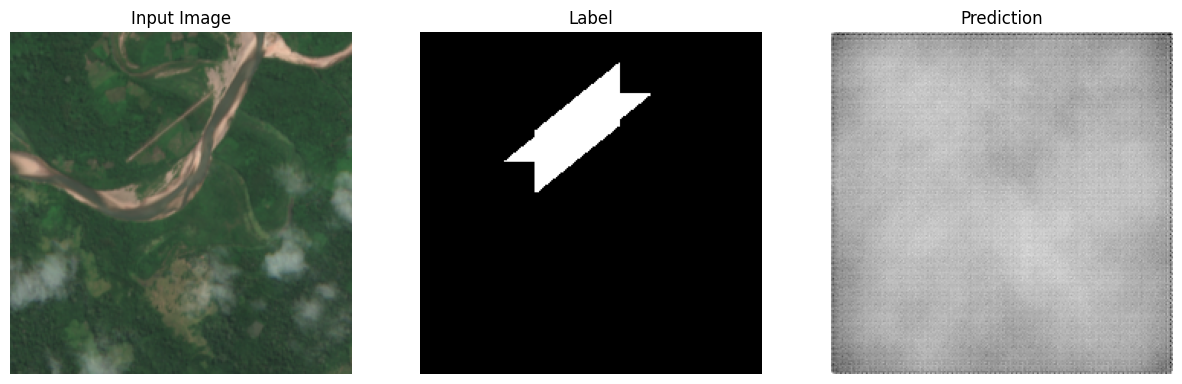

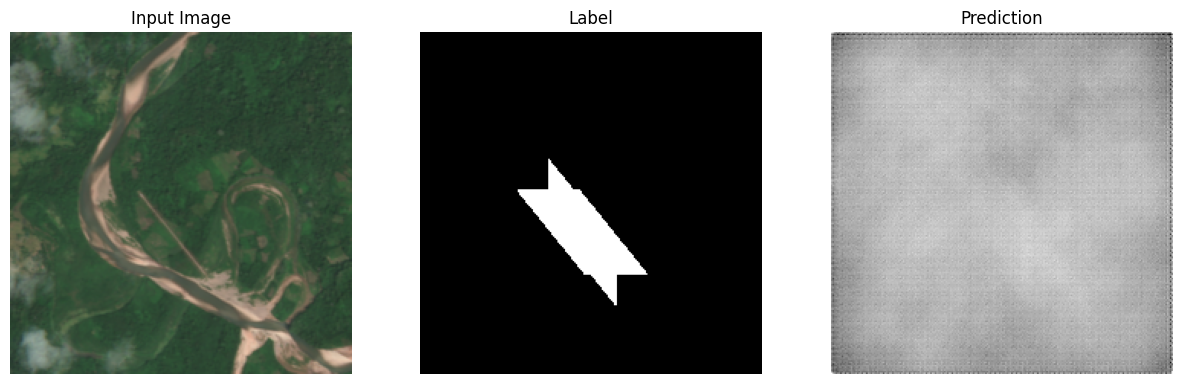

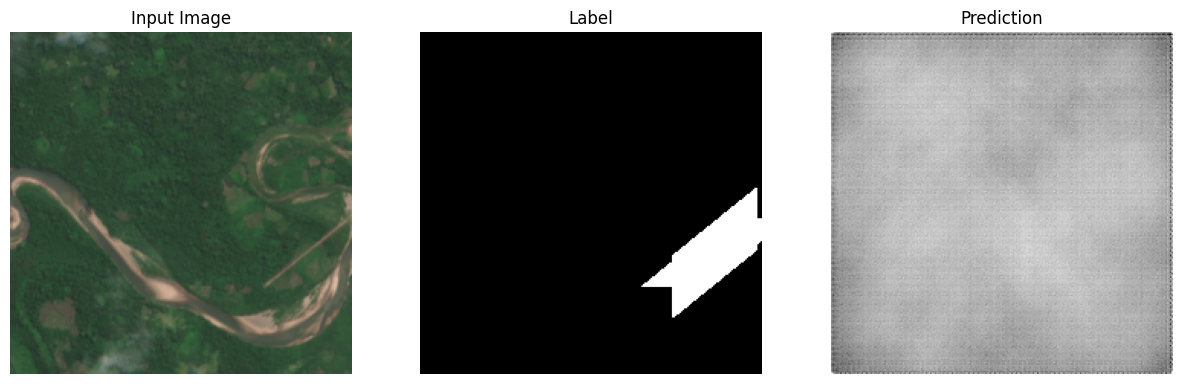

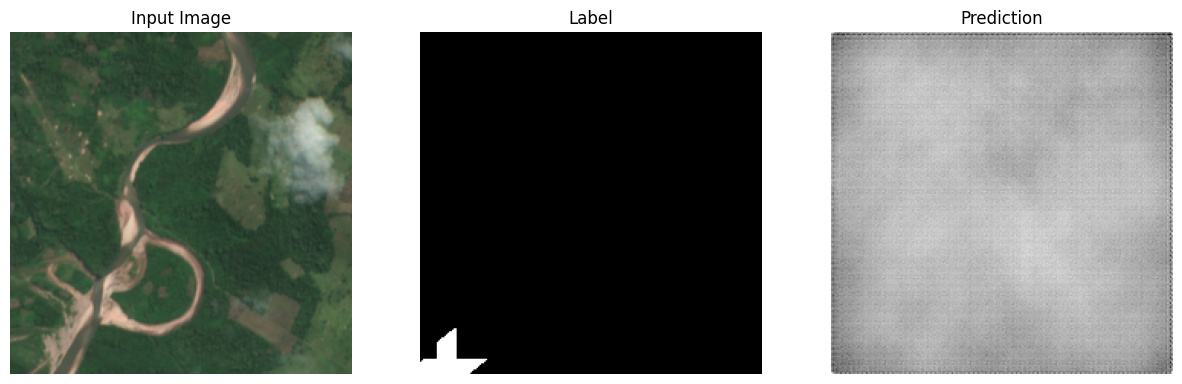

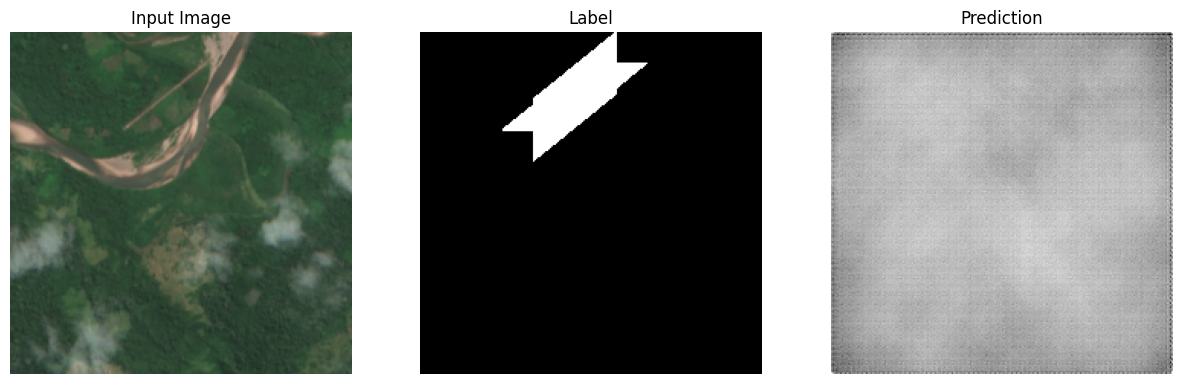

In [24]:
# Visualize predictions for a few TRAINING samples
visualize_predictions(model, train_dataset, num_samples=5)